# Projeto 2 - CDados

### Autores: Diego Guimarães Nuñez, Felipe Bakowski Nantes de Souza, Gustavo de Lima Mota

### Tema: Conseguimos prever o número de homicídios nos municípios do Estado de SP, que não são capital, em um ano no estado de São Paulo?

### Features: IDH por município, Proporção de crianças (6-14 anos) fora da escola, Proporção de vulnerabilidade socioeconêmica, Proporção de pessoas sem água e esgoto, e Índice de Gini por município.

In [450]:
import basedosdados as bd
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

### Baixando as bases de dados utilizadas no projeto:

In [258]:
homicidio = bd.read_table(dataset_id='br_sp_gov_ssp',
table_id='ocorrencias_registradas',
billing_project_id="cdadosp2-404421")

Downloading: 100%|██████████| 153876/153876 [00:30<00:00, 5091.45rows/s]


In [260]:
ivs = bd.read_table(dataset_id='br_ipea_avs',
table_id='municipio',
billing_project_id="cdadosp2-404421")

Downloading: 100%|██████████| 319681/319681 [06:23<00:00, 834.07rows/s] 


## Refletindo sobre os problemas sociais presentes em São Paulo, um dos mais notáveis é a abundante taxa de criminalidade, especificando ainda mais, a taxa de homicídio. Visado a target (problema o qual é pretendido visualizar), foi-se pensado em possíveis targets quais estão ligadas com o tema tido em vista, que são: Índice de Gini, Indice de desenvolvimento Humano, Proporcao de populacao sem esgoto, Proporcao de crianças que sairam da escola entre 6 a 14 anos e Proporcao de Vulnerabilidade Socioeconomica.
## Tendo em vista a target com suas respectivas features, é pretendido realizar a criação de um modelo com capacidade de previsão para a criminalidade, entendendo intrinsicamente as relações individuais de cada feature com a target. A partir da criação do modelo, é facilitada a visão das 'raízes' do problema, possibilitando possíveis tomadas de decisões pessoais e governamentais para tratar esse severo problema.

#### Primeiramente, vamos tratar a base de dados de homicidios e deixá-la mais visualizável

In [447]:
homicidio['Homicidio_total'] = homicidio.loc[:, ['homicidio_doloso', 'homicidio_culposo_outros']].sum(axis=1) #homicidio total
homicidio_2010 = homicidio.loc[(homicidio['ano'] == 2010)]
homicidio_filtrado = homicidio_2010.loc[:,('ano','id_municipio', 'regiao_ssp', 'Homicidio_total')] #selecionando colunas
homicidio_ano = homicidio_filtrado.groupby(['ano', 'id_municipio', 'regiao_ssp']).agg({'Homicidio_total': 'sum'}).reset_index()

 ## Agora devemos tratar a base IVS, para que, consigamos utilizar as colunas:  Prop_crianca_fora_escola_6_14, IDHM (IDH por municipio), Proporção_vulnerabilidade_socioeconomica (proporção de pessoas com renda per capita inferior a meio salario mínimo e que gastam mais de uma hora até chegar no trabalho), proporção_sem_agua_esgoto, Índice de Gini

In [446]:
#filtrando ivs
ivs_filtrado = ivs.loc[:,('ano','id_municipio','sigla_uf','idhm','renda_per_capita','proporcao_analfabetismo_15_mais', 'proporcao_sem_renda_18_mais','indice_gini')]
ivs_t = ivs_filtrado.loc[(ivs['sigla_uf'] == 'SP') & (ivs['ano'] == 2010)]
ivs_novo = ivs_t.dropna()
ivs_novo2 = ivs_novo.drop_duplicates(subset='id_municipio', keep = 'first')

#criando tabela 
tabela_final = pd.merge(ivs_novo2, homicidio_ano[['id_municipio', 'Homicidio_total']], on='id_municipio', how='left')
tabela_definitiva = tabela_final.dropna()
tabela_definitiva.loc[tabela_definitiva['Homicidio_total']==1260] # identificando São Paulo
tabela_sem_sp = tabela_definitiva.drop(tabela_definitiva.loc[tabela_definitiva['Homicidio_total']==1260].index) # tirando São Paulo
tabela_sem_sp.describe()

,ano,idhm,renda_per_capita,proporcao_analfabetismo_15_mais,proporcao_sem_renda_18_mais,indice_gini,Homicidio_total
count,639.0,639.000000,639.000000,639.000000,639.000000,639.000000,639.000000
mean,2010.0,0.763746,802.356620,6.071049,3.066182,0.456135,5.244131
std,0.0,0.034519,240.292539,2.441283,2.853549,0.059192,13.881830
min,2010.0,0.655000,348.790000,1.010000,0.000000,0.320000,0.000000
25%,2010.0,0.742000,649.415000,4.280000,1.290000,0.410000,0.000000
50%,2010.0,0.763000,761.590000,5.840000,2.080000,0.450000,1.000000
75%,2010.0,0.785000,904.240000,7.485000,3.835000,0.490000,4.000000
max,2010.0,0.891000,2729.860000,17.090000,24.480000,0.740000,168.000000


## Agora deve-se dividir o nosso dataframe em treino e teste

In [441]:
tabela_sem_sp = tabela_sem_sp.sample(frac=1)
df_treino = tabela_sem_sp[0:448]
df_teste = tabela_sem_sp[448:639]

## Entendendo como a target (homicídio) se comporta em relação aos municípios

## De início, tem-se um crosstab da porcentagem de homicícios, por município, em 2010.Além de, um gráfico de barras do homicídio, no Estado, dos municípios. Tal que, este será utilizado para a validação do modelo no futuro

In [491]:
homicidio_mun = homicidio.groupby(['ano','id_municipio','regiao_ssp']).agg({'Homicidio_total': 'sum'}).reset_index()
homicidio_mun = homicidio_mun.loc[(homicidio_mun['regiao_ssp']!='Capital')] #retirando a capital
homicidio_mun_2010 = homicidio_mun.loc[homicidio_mun.ano == 2010]

In [492]:
pd.crosstab(homicidio_mun_2010.Homicidio_total, homicidio_mun_2010.id_municipio, margins=True).round(4)

id_municipio,3500105,3500204,3500303,3500402,3500501,3500550,3500600,3500709,3500758,3500808,...,3556701,3556800,3556909,3556958,3557006,3557105,3557154,3557204,3557303,All
Homicidio_total,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,0,1,0,1,0,1,1,...,0,0,1,1,0,0,1,0,1,239
1.0,1,1,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,124
2.0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,58
3.0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,45
4.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30
5.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24
6.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,9
7.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
8.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


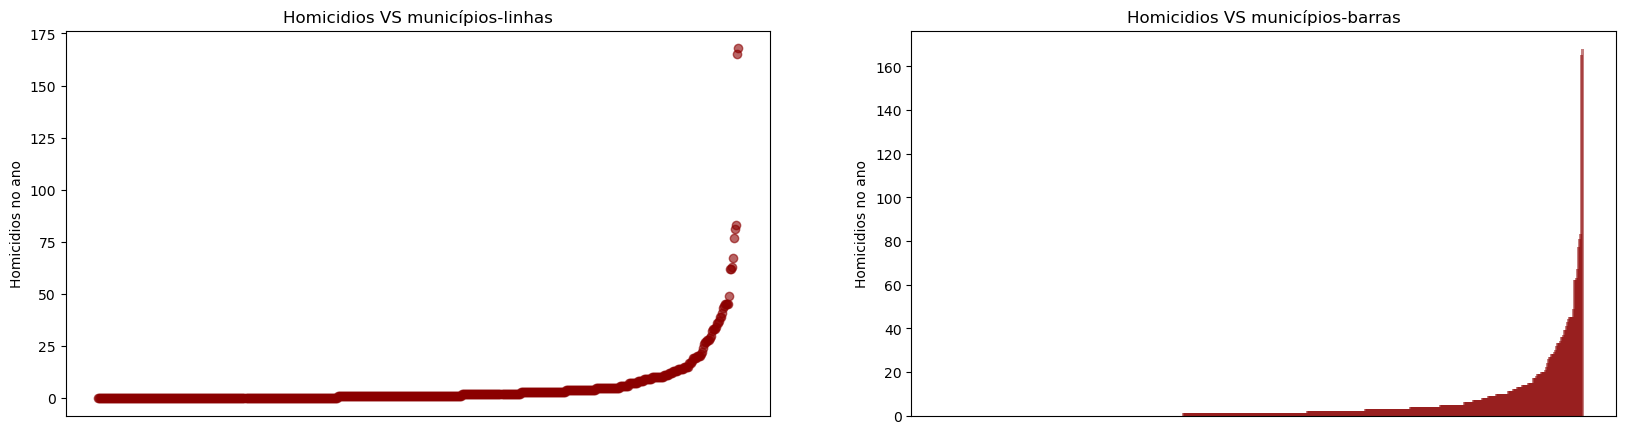

In [495]:
hom_ord = homicidio_mun_2010.sort_values('Homicidio_total')#ordenando os valores para ajudar na visibilidade

plt.figure(figsize=(20,5))


plt.subplot(1,2,1)
plt.scatter(hom_ord.id_municipio, hom_ord.Homicidio_total, color='darkred', alpha=0.6)
plt.xlabel('Municípios')
plt.gca().axes.get_xaxis().set_visible(False) #retirando a legenda no eixo x, estava muito poluido
plt.ylabel('Homicidios no ano')
plt.title('Homicidios VS municípios-linhas')

plt.subplot(1,2,2)
plt.bar(hom_ord.id_municipio, hom_ord.Homicidio_total, color='darkred', width=3, alpha=0.5)
plt.xlabel('Municípios')
plt.gca().axes.get_xaxis().set_visible(False) #retirando a legenda no eixo x, estava muito poluido
plt.ylabel('Homicidios no ano')
plt.title('Homicidios VS municípios-barras')


plt.show()

 ## Então, deve-se entender as correlações entre as features e variáveis, para que seja possível diagnosticar futuros erros

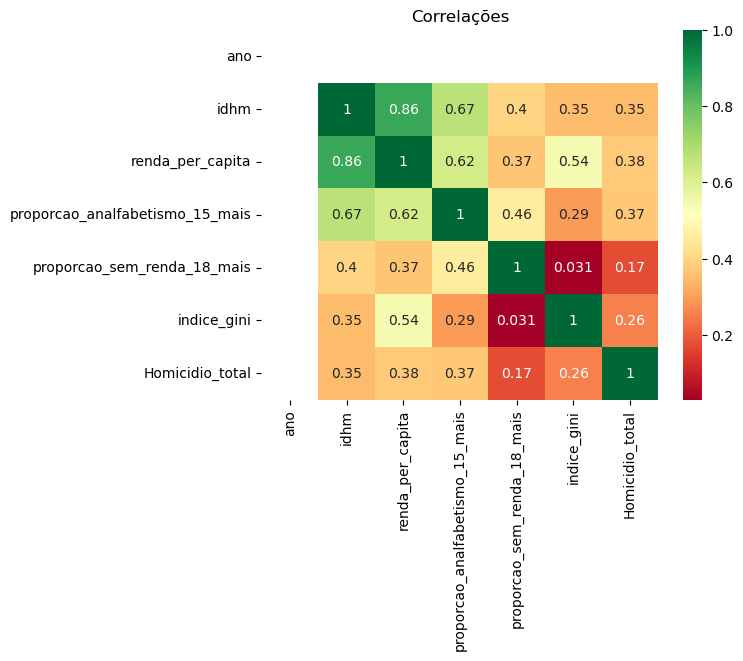

In [278]:
sns.heatmap(abs(tabela_sem_sp.corr()), annot = True, cmap= "RdYlGn") #nota : apenas para valores absolutos
plt.title('Correlações')
plt.show()

# Por fim, plota-se os gráficos de dispersão + .corr

### Nota: Esses gráficos de dispersão são referentes ao ano 2010

Correlação entre homicídios e idhm é moderada e possui valor de 0.3878018840686981
Correlação entre homicídios e renda per capita é moderada e possui valor de 0.41431841347234083
Correlação entre homicídios e prop. de analfabetismo é moderada e possui valor de -0.40108130297237926
Correlação entre homicídios e prop. pessoas sem renda é fraca e possui valor de -0.18966581648180225
Correlação entre homicídios e indice gini é fraca e possui valor de 0.2700563614585964


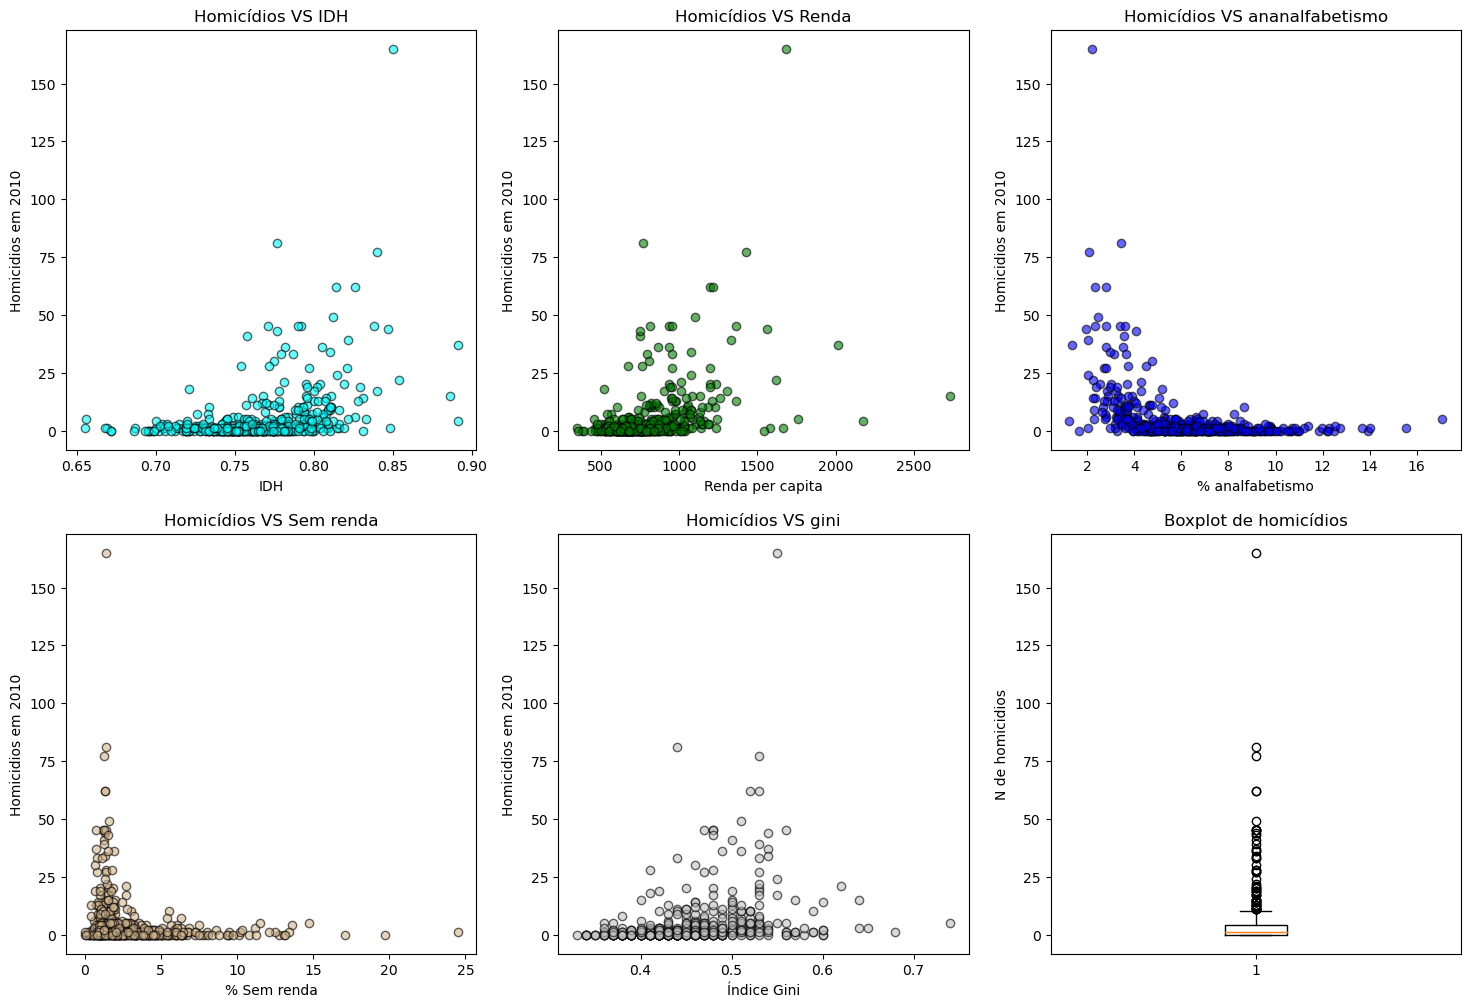

In [420]:
plt.figure(figsize=(18,12))

plt.subplot(2,3,1)
plt.scatter(df_treino['idhm'], df_treino['Homicidio_total'], alpha=0.6, color='cyan', edgecolors="black")
plt.xlabel('IDH')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS IDH')
corr_idhm = df_treino['Homicidio_total'].corr(df_treino['idhm'])
if abs(corr_idhm) < 0.3:
    print(f'Correlação entre homicídios e idhm é fraca e possui valor de {corr_idhm}')
elif abs(corr_idhm) >0.3 and (corr_idhm) < 0.7:
    print(f'Correlação entre homicídios e idhm é moderada e possui valor de {corr_idhm}')
elif abs(corr_idhm) > 0.7:
    print(f'Correlação entre homicídios e idhm é forte e possui valor de {corr_idhm}')

plt.subplot(2,3,2)
plt.scatter(df_treino['renda_per_capita'], df_treino['Homicidio_total'], alpha=0.6, color='green', edgecolors="black")
plt.xlabel('Renda per capita')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS Renda')
corr_renda = df_treino['Homicidio_total'].corr(df_treino['renda_per_capita'])
if abs(corr_renda) < 0.3:
    print(f'Correlação entre homicídios e renda per capita é fraca e possui valor de {corr_renda}')
elif abs(corr_renda) >0.3 and (corr_renda) < 0.7:
    print(f'Correlação entre homicídios e renda per capita é moderada e possui valor de {corr_renda}')
elif abs(corr_renda) > 0.7:
    print(f'Correlação entre homicídios e renda per capita é forte e possui valor de {corr_renda}')

plt.subplot(2,3,3)
plt.scatter(df_treino['proporcao_analfabetismo_15_mais'], df_treino['Homicidio_total'], alpha=0.6, color='blue', edgecolors="black")
plt.xlabel('% analfabetismo')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS ananalfabetismo')
corr_analfab = df_treino['Homicidio_total'].corr(df_treino['proporcao_analfabetismo_15_mais'])
if abs(corr_analfab) < 0.3:
    print(f'Correlação entre homicídios e prop. de analfabetismo é fraca e possui valor de {corr_analfab}')
elif abs(corr_analfab) >0.3 and (corr_analfab) < 0.7:
    print(f'Correlação entre homicídios e prop. de analfabetismo é moderada e possui valor de {corr_analfab}')
elif abs(corr_analfab) > 0.7:
    print(f'Correlação entre homicídios e prop. de analfabetismo é forte e possui valor de {corr_analfab}')

plt.subplot(2,3,4)
plt.scatter(df_treino['proporcao_sem_renda_18_mais'], df_treino['Homicidio_total'], alpha=0.6, color='tan', edgecolors="black")
plt.xlabel('% Sem renda')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS Sem renda')
corr_sem_renda = df_treino['Homicidio_total'].corr(df_treino['proporcao_sem_renda_18_mais'])
if abs(corr_sem_renda) < 0.3:
    print(f'Correlação entre homicídios e prop. pessoas sem renda é fraca e possui valor de {corr_sem_renda}')
elif abs(corr_sem_renda) >0.3 and (corr_sem_renda) < 0.7:
    print(f'Correlação entre homicídios e prop. pessoas sem renda é moderada e possui valor de {corr_sem_renda}')
elif abs(corr_sem_renda) > 0.7:
    print(f'Correlação entre homicídios e prop. pessoas sem renda é forte e possui valor de {corr_sem_renda}')

plt.subplot(2,3,5)
plt.scatter(df_treino['indice_gini'], df_treino['Homicidio_total'], alpha=0.6, color='silver', edgecolors="black")
plt.xlabel('Índice Gini')
plt.ylabel('Homicidios em 2010')
plt.title('Homicídios VS gini')
corr_gini = df_treino['Homicidio_total'].corr(df_treino['indice_gini'])
if abs(corr_gini) < 0.3:
    print(f'Correlação entre homicídios e indice gini é fraca e possui valor de {corr_gini}')
elif abs(corr_gini) >0.3 and (corr_gini) < 0.7:
    print(f'Correlação entre homicídios e indice gini é moderada e possui valor de {corr_gini}')
elif abs(corr_gini) > 0.7:
    print(f'Correlação entre homicídios e indice gini é forte e possui valor de {corr_gini}')

plt.subplot(2,3,6)
plt.boxplot(df_treino['Homicidio_total'])
plt.title('Boxplot de homicídios')
plt.ylabel('N de homicidios')

plt.show()

## Possíveis fontes de erro!

### Ao analisarmos a função .agg observamos que ela fazia com que existisse alguns pontos aberrantes, por exemplo, em sp tinhamos 1260 homicídios. Logo, tiramos esse ponto aberrante e trabalharemos com essa possibilidade de erro para as próximas análises

## Agora iremos criar um modelo de regressão linear com múltiplas variáveis

In [280]:
def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

In [281]:
X = tabela_sem_sp[['idhm','renda_per_capita','proporcao_analfabetismo_15_mais', 'proporcao_sem_renda_18_mais','indice_gini']]

Y = tabela_sem_sp['Homicidio_total']

In [282]:
modelo_regress = regress(Y, X)

modelo_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Homicidio_total   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     27.39
Date:                Thu, 23 Nov 2023   Prob (F-statistic):           3.94e-25
Time:                        15:14:49   Log-Likelihood:                -2524.6
No. Observations:                 639   AIC:                             5061.
Df Residuals:                     633   BIC:                             5088.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -8.3862     23.407     -0.358      0.720     -54.350      37.578
idhm                                4.8750     31.458      0.155      0.877     -56.899      66.649
renda_per_capita                    0.0100      0.005      2.069      0.039       0.001       0.020
proporcao_analfabetismo_15_mais    -1.2888      0.291     -4.433      0.000      -1.860      -0.718
proporcao_sem_renda_18_mais        -0.0233      0.207     -0.112      0.911      -0.430       0.383
indice_gini                        21.4273     10.906      1.965      0.050       0.011      42.844
==============================================================================
Omnibus:                      831.034   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           120627.302
Skew:                           6.603   Prob(JB):                         0.00
Kurtosis:                      69.002   Cond. No.                     6.56e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Então, precisamos analisar quais variáveis serão desejáveis para a análise. Para isso iremos utilizar um processo iterativo de rodar o modelo e avaliar se o valor P está acima de 10% (índice de significância), caso esteja, ele deverá ser retirado e rodaremos o modelo denovo até que achemos todas as variáveis relevantes.

In [283]:
X = tabela_sem_sp[['idhm','renda_per_capita','proporcao_analfabetismo_15_mais','indice_gini']] #retirando prop_agua_sem_esgoto

Y = tabela_sem_sp['Homicidio_total']

In [284]:
modelo_regress = regress(Y, X)

modelo_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Homicidio_total   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     34.28
Date:                Thu, 23 Nov 2023   Prob (F-statistic):           6.31e-26
Time:                        15:14:49   Log-Likelihood:                -2524.6
No. Observations:                 639   AIC:                             5059.
Df Residuals:                     634   BIC:                             5081.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -8.3205     23.381     -0.356      0.722     -54.234      37.593
idhm                                4.8847     31.433      0.155      0.877     -56.840      66.610
renda_per_capita                    0.0101      0.005      2.114      0.035       0.001       0.019
proporcao_analfabetismo_15_mais    -1.2983      0.278     -4.671      0.000      -1.844      -0.753
indice_gini                        21.0874     10.469      2.014      0.044       0.529      41.646
==============================================================================
Omnibus:                      830.887   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           120527.685
Skew:                           6.601   Prob(JB):                         0.00
Kurtosis:                      68.974   Cond. No.                     6.56e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [285]:
X = tabela_sem_sp[['renda_per_capita','proporcao_analfabetismo_15_mais', 'indice_gini']] #retirando prop_agua_sem_esgoto

Y = tabela_sem_sp['Homicidio_total']

In [286]:
modelo_regress = regress(Y, X)

modelo_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Homicidio_total   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     45.77
Date:                Thu, 23 Nov 2023   Prob (F-statistic):           8.63e-27
Time:                        15:14:49   Log-Likelihood:                -2524.6
No. Observations:                 639   AIC:                             5057.
Df Residuals:                     635   BIC:                             5075.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -4.7628      4.747     -1.003      0.316     -14.085       4.560
renda_per_capita                    0.0107      0.003      3.519      0.000       0.005       0.017
proporcao_analfabetismo_15_mais    -1.3126      0.262     -5.009      0.000      -1.827      -0.798
indice_gini                        20.6499     10.076      2.049      0.041       0.864      40.436
==============================================================================
Omnibus:                      830.633   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           120381.557
Skew:                           6.597   Prob(JB):                         0.00
Kurtosis:                      68.934   Cond. No.                     1.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Agora que apenas as features relevantes sobraram, devemos análisar a correlação entre os erros do modelo. Para isso, utilizaremos o valor de Durbin-Watson.

## No caso, esse valor é de 1,865

In [287]:
resultado = 2*(1-1.878)

In [288]:
resultado

-1.7559999999999998

## Como esse resultado está muito próximo de 2, pode-se afirmar que a correlação entre os erros é bem baixa !

## Agora, nós podemos fazer uma análise da nossa regressão linear composta e avaliar se ela responde a nossa pergunta inicial

In [522]:
y = modelo_regress.predict()
df_modelo1 = tabela_sem_sp.loc[:, ('id_municipio', 'Homicidio_total', 'indice_gini', 'renda_per_capita', 'proporcao_analfabetismo_15_mais')]
df_modelo1['y'] = y
df_modelo1['diferença'] = df_modelo1.Homicidio_total-df_modelo1.y
df_modelo1 = df_modelo1.sort_values('diferença')

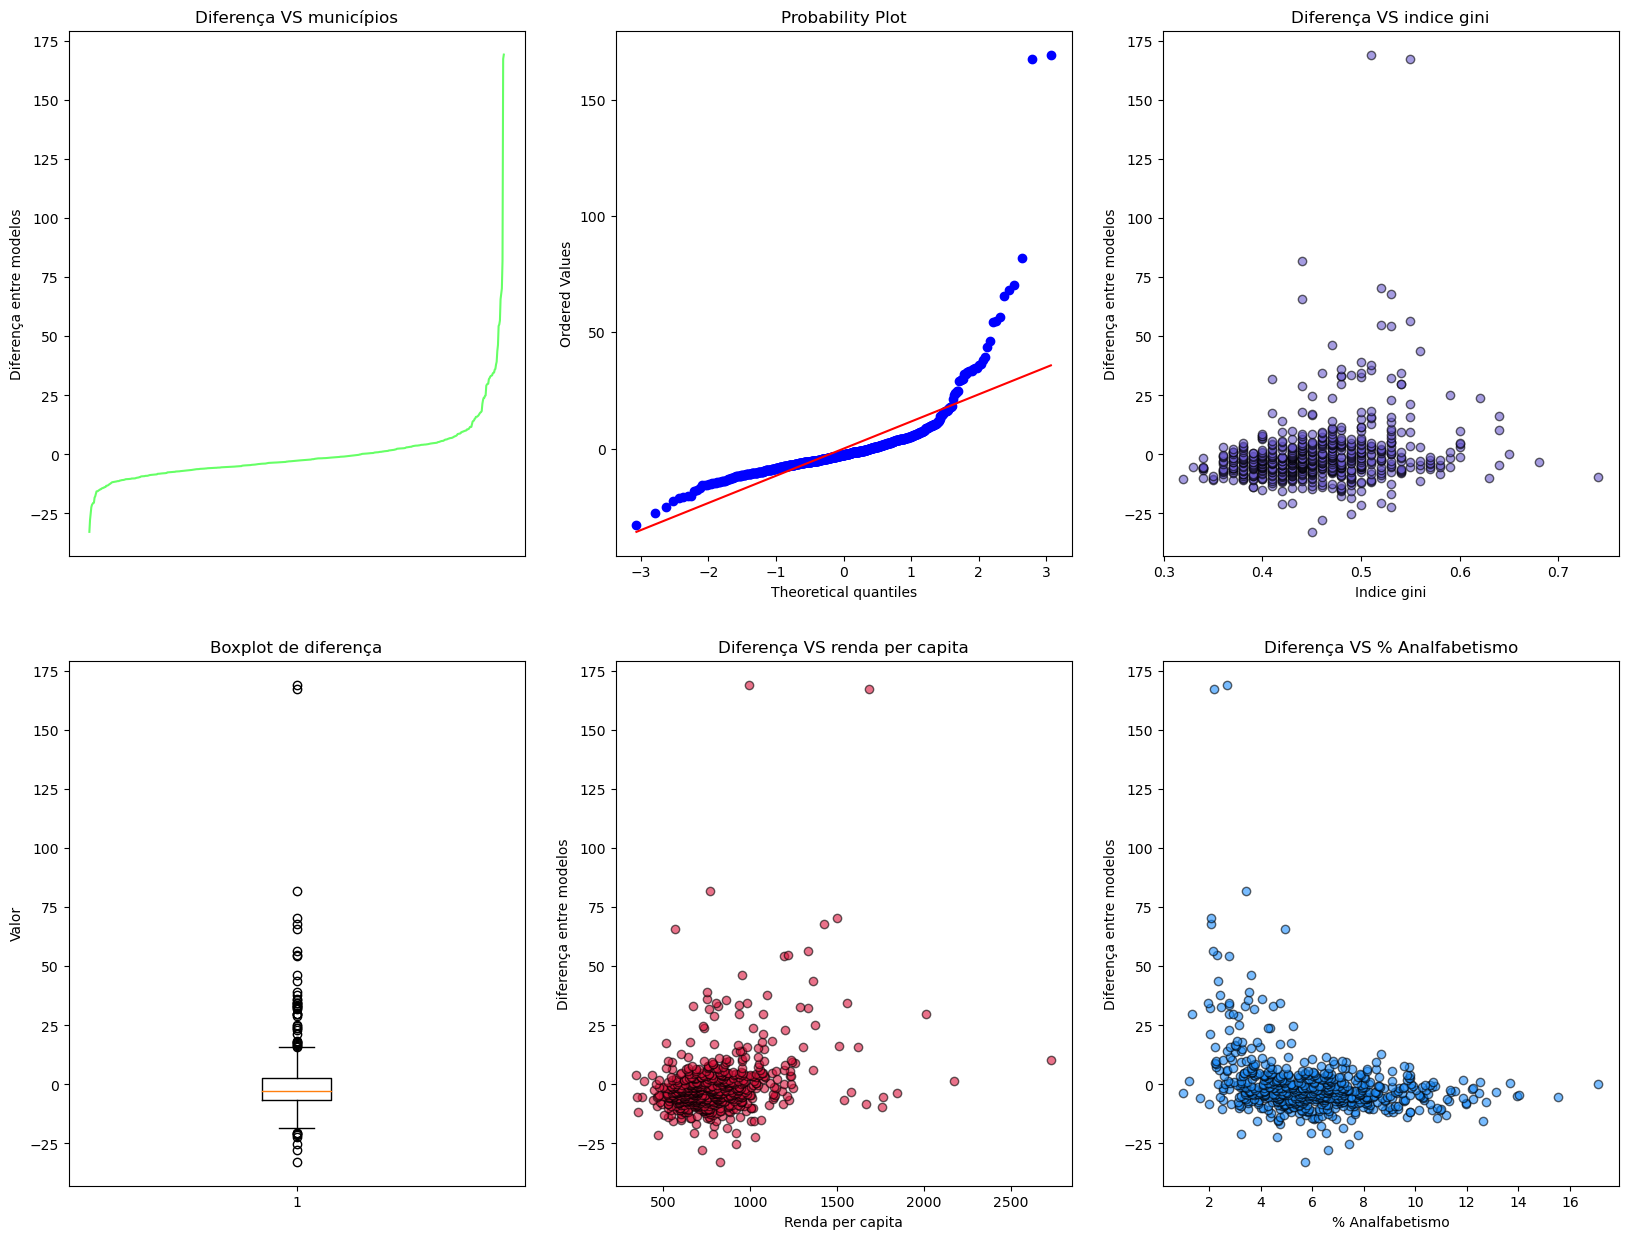

In [542]:
plt.figure(figsize=(20,15))

#diferença entre os dois modelos
plt.subplot(2,3,1)
plt.plot(df_modelo1.id_municipio, df_modelo1.diferença, color='lime', alpha=0.6)
plt.gca().axes.get_xaxis().set_visible(False) #retirando a legenda no eixo x, estava muito poluido
plt.ylabel('Diferença entre modelos')
plt.title('Diferença VS municípios')

#probplot dos resíduis
plt.subplot(2,3,2)
stats.probplot(df_modelo1.diferença, dist='norm', plot=plt)

#diferença vs indice_gini
plt.subplot(2,3,3)
plt.scatter(df_modelo1.indice_gini, df_modelo1.diferença, color='slateblue', alpha=0.6, edgecolors='black')
plt.ylabel('Diferença entre modelos')
plt.xlabel('Indice gini')
plt.title('Diferença VS indice gini')

#boxplot da diferença
plt.subplot(2,3,4)
plt.boxplot(df_modelo1['diferença'])
plt.title('Boxplot de diferença')
plt.ylabel('Valor')

#Diferença vs renda per capita
plt.subplot(2,3,5)
plt.scatter(df_modelo1.renda_per_capita, df_modelo1.diferença, color='crimson', alpha=0.6, edgecolors='black')
plt.ylabel('Diferença entre modelos')
plt.xlabel('Renda per capita')
plt.title('Diferença VS renda per capita')

#Diferença vs analfabetismo
plt.subplot(2,3,6)
plt.scatter(df_modelo1.proporcao_analfabetismo_15_mais, df_modelo1.diferença, color='dodgerblue', alpha=0.6, edgecolors='black')
plt.ylabel('Diferença entre modelos')
plt.xlabel('% Analfabetismo')
plt.title('Diferença VS % Analfabetismo')

plt.show()

## Com o nosso primeiro modelo completo, agora devemos partir para a formação no segundo. Este será feito através de uma arvore de decisões

In [290]:
arvore_regressao = DecisionTreeRegressor()

Xa = df_treino[['idhm','renda_per_capita','proporcao_analfabetismo_15_mais', 'proporcao_sem_renda_18_mais','indice_gini']]
Ya = df_treino['Homicidio_total']

arvore_regressao.fit(Xa, Ya)

DecisionTreeRegressor()

In [291]:
Xteste = df_teste[['idhm','renda_per_capita','proporcao_analfabetismo_15_mais', 'proporcao_sem_renda_18_mais','indice_gini']]
Yteste = df_teste['Homicidio_total']

prev_y = arvore_regressao.predict(Xteste)

mae = mean_absolute_error(Yteste, prev_y)
mse = mean_squared_error(Yteste, prev_y)
r2 = r2_score(Yteste, prev_y)

print(mae)
print(mse)
print(r2)

6.230366492146596
276.24083769633506
-0.10809655370488147
